In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from data_utility import *
from data_utils import *
from loss import *
from train import *
from deeplab_model.deeplab import *
from sync_batchnorm import convert_model
import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
USE_GPU = True
NUM_WORKERS = 12
BATCH_SIZE = 2

dtype = torch.float32 
# define dtype, float is space efficient than double

if USE_GPU and torch.cuda.is_available():
    
    device = torch.device('cuda')
    
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    # magic flag that accelerate
    
    print('using GPU for training')
else:
    device = torch.device('cpu')
    print('using CPU for training')

using GPU for training


In [3]:
train_dataset = pyramid_dataset(data_type = 'nii_train', 
                transform=transforms.Compose([
                random_affine(90, 15),
                random_filp(0.5)]))
# do data augumentation on train dataset

validation_dataset = pyramid_dataset(data_type = 'nii_test', 
                transform=None)
# no data augumentation on validation dataset

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True,
                    num_workers=NUM_WORKERS) # drop_last
# loaders come with auto batch division and multi-thread acceleration

In [16]:
min_val, epoch = get_min_validation('train_deeplab_output_16_elu.txt')
print(min_val, epoch)
checkpoint_file = find_file_with_epoch(epoch, '../deeplab_output_16_elu_save')
print(checkpoint_file)

0.0577 537
../deeplab_output_16_elu_save/2019-08-22 12:34:12.880653 epoch: 537.pth


In [17]:
deeplab = DeepLab_ELU(output_stride=16)
#deeplab = DeepLabModified(output_stride=8, elu=True)
deeplab = nn.DataParallel(deeplab)
deeplab = convert_model(deeplab)

#checkpoint = torch.load('../deeplab_save/2019-07-29 00:44:11.825872.pth')
#checkpoint = torch.load('../deeplab_dilated_save/2019-08-01 08:57:17.225282.pth') # best one
#checkpoint = torch.load('../deeplab_dilated_save/2019-08-07 21:09:31.794340 epoch: 850.pth') # latest one
#checkpoint = torch.load('../deeplab_save/2019-07-29 00:15:49.271222.pth')
#checkpoint = torch.load('../deeplab_dilated_save/2019-08-09 10:58:04.937907 epoch: 1045.pth')
#checkpoint = torch.load('../deeplab_dilated_save/2019-08-09 11:21:44.250423 epoch: 1047.pth')
checkpoint = torch.load(checkpoint_file) 

deeplab.load_state_dict(checkpoint['state_dict_1'])
deeplab = deeplab.to(device, dtype)

epoch = checkpoint['epoch']
print(epoch)


537


1it [00:20, 20.70s/it]

0.0037973523139953613 0.06569141149520874 0.1345881223678589 0.0680256336927414


2it [00:23, 15.37s/it]

0.005368351936340332 0.0644407868385315 0.14602351188659668 0.0719442218542099


3it [00:26, 11.72s/it]

0.0045615434646606445 0.06423306465148926 0.12044578790664673 0.06308013200759888
0.0034444332122802734 0.0856482982635498 0.1803463101387024 0.08981301635503769


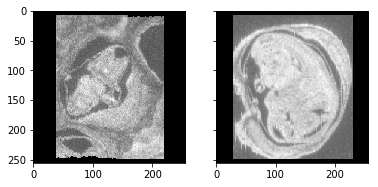

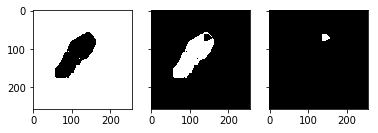

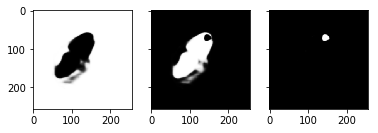

5it [00:31,  6.97s/it]

0.003422379493713379 0.07876843214035034 0.08880895376205444 0.056999921798706055
0.004325151443481445 0.08237028121948242 0.11936295032501221 0.06868612766265869


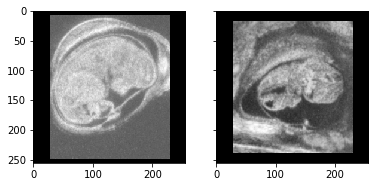

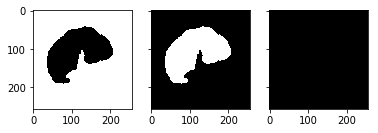

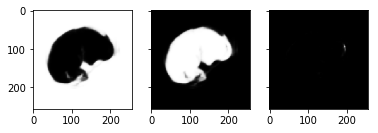

7it [00:36,  4.54s/it]

0.0038040876388549805 0.07297635078430176 0.1121874451637268 0.06298929452896118


8it [00:38,  3.65s/it]

0.0036880970001220703 0.06615018844604492 0.13490939140319824 0.06824922561645508


9it [00:39,  3.07s/it]

0.0037626028060913086 0.06934809684753418 0.12159335613250732 0.06490135192871094
0.003945767879486084 0.09640836715698242 0.14712917804718018 0.08249443769454956


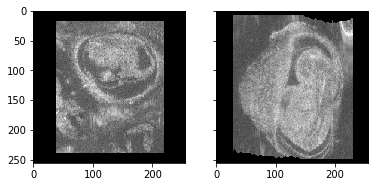

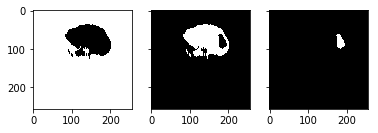

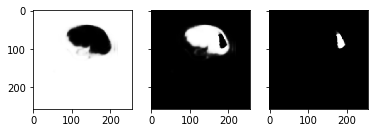

11it [00:44,  2.63s/it]

0.0036069154739379883 0.07835698127746582 0.17994904518127441 0.08730431646108627
0.003180861473083496 0.0871049165725708 0.1157534122467041 0.06867973506450653


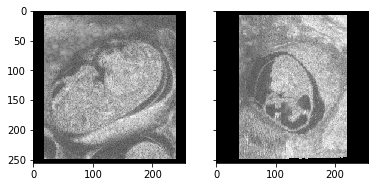

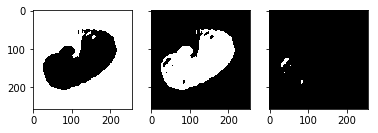

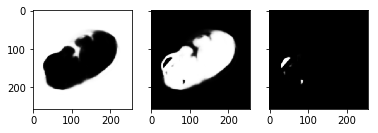

13it [00:49,  2.44s/it]

0.0043364763259887695 0.07089686393737793 0.138807475566864 0.0713469386100769
0.0038933753967285156 0.1023789644241333 0.12762463092803955 0.07796566188335419


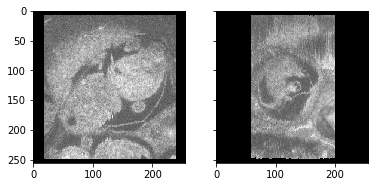

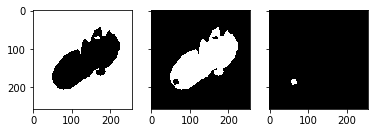

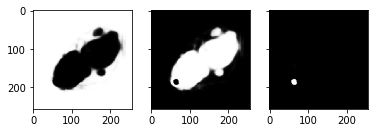

14it [00:51,  2.55s/it]

0.003069639205932617 0.08214879035949707 0.09793198108673096 0.061050139367580414


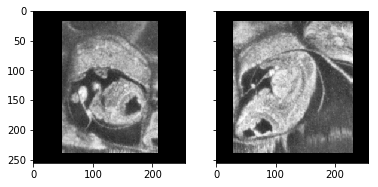

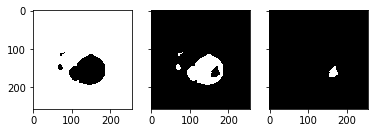

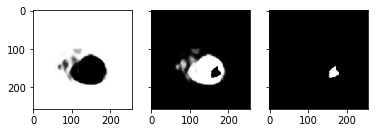

16it [00:56,  2.36s/it]

0.004141688346862793 0.056253254413604736 0.15113937854766846 0.07051144540309906


17it [00:58,  2.19s/it]

0.003938198089599609 0.07147777080535889 0.11070394515991211 0.062039971351623535


18it [00:59,  2.03s/it]

0.003165602684020996 0.07336390018463135 0.11196422576904297 0.06283124536275864


19it [01:01,  1.95s/it]

0.004720568656921387 0.06912672519683838 0.12810999155044556 0.06731909513473511
0.0032849907875061035 0.09789788722991943 0.15756791830062866 0.08625026792287827


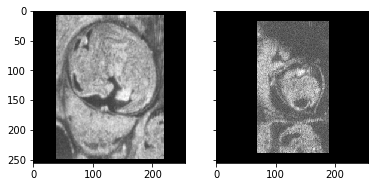

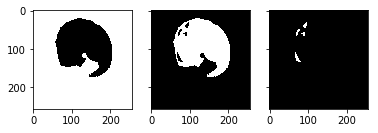

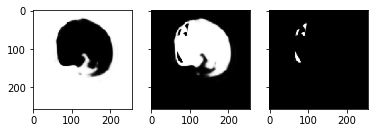

20it [01:04,  2.21s/it]

In [ ]:
# output 4 w/ ELU: ------- background loss = 0.0036, body loss = 0.0727, bv loss = 0.1289
# output 8 w/ ELU: ------- background loss = 0.0037, body loss = 0.0739, bv loss = 0.1176
# output 16 w/ ELU:

deeplab.eval()

with torch.no_grad():
    
    bgloss = 0
    bdloss = 0
    bvloss = 0
    
    for v, vbatch in tqdm(enumerate(validation_loader)):
            # move data to device, convert dtype to desirable dtype

        image_1 = vbatch['image1_data'].to(device=device, dtype=dtype)
        label_1 = vbatch['image1_label'].to(device=device, dtype=dtype)

        output = deeplab(image_1)
        # do the inference
        output_numpy = output.cpu().numpy()
        
        
        #out_1 = torch.round(output)
        out_1 = torch.from_numpy((output_numpy == output_numpy.max(axis=1)[:, None]).astype(int)).to(device=device, dtype=dtype)
        loss_1 = dice_loss_3(out_1, label_1)

        bg, bd, bv = dice_loss_3_debug(out_1, label_1)
        # calculate loss
        print(bg.item(), bd.item(), bv.item(), loss_1.item())
        bgloss += bg.item()
        bdloss += bd.item()
        bvloss += bv.item()
        
        if bv.item() >= 0.2 or bd.item() >= 0.08:
            show_image_slice(image_1)
            show_image_slice(label_1)
            show_image_slice(output)

    outstr = '------- background loss = {0:.4f}, body loss = {1:.4f}, bv loss = {2:.4f}'\
        .format(bgloss/(v+1), bdloss/(v+1), bvloss/(v+1)) + '\n'
    
    #print(bdloss, v)
    print(outstr)